In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress,ttest_ind

In [2]:
# read raw data; Tmean = daily mean temperature; Tmax = daily maximum Temperature
pfad='DATA\\DWD\\'
dfp = pd.read_csv(''+str(pfad)+'tmax_19510101_20241231_04336-Saarbruecken.csv', parse_dates=['date'])
print(dfp.head())

        date  Tmean  Tmax
0 1951-01-01    0.7   2.0
1 1951-01-02    1.0   2.0
2 1951-01-03    0.4   1.0
3 1951-01-04    0.4   1.5
4 1951-01-05    4.2   6.0


In [3]:
# Replacing missing values (-999) with NaN and counting them
dfp.replace(-999, np.nan, inplace=True)
nan_rows = dfp.isnull().any(axis=1).sum()
print(nan_rows)

0


In [4]:
# Check for data gaps 
df=dfp.copy()
df = df.sort_values(by='date')
df['date_diff'] = df['date'].diff()
gaps = df[df['date_diff'] > pd.Timedelta(days=1)]
print(gaps)

Empty DataFrame
Columns: [date, Tmean, Tmax, date_diff]
Index: []


In [5]:
# There were two significant changes at station 04336:  
# 1.) Relocation in the year 1984  
# 2.) Installation of a new measurement sensor in 1996  
# The following analysis tests whether these changes led to systematically different Tmax measurements.  
# To achieve this, the trend is first removed from the Tmax time series.

y1=1984
y2=1996

def calc_trend(tdata, x_key, y_key):
    x = tdata[x_key].dt.year.astype(int)
    y = tdata[y_key]
    slope, interc, _, _, _ = linregress(x, y)
    trend = slope * x + interc
    return x, trend, slope

x1_tmax, trend_tmax, slope1_tmax = calc_trend(df, 'date', 'Tmax')
df['Tmax_resid'] = df['Tmax'] - trend_tmax

df['year'] = df['date'].dt.year

yyy=y1
bef = df[(df['year'] >= (yyy-10)) & (df['year'] <= (yyy-1))]
aft = df[(df['year'] >= (yyy+1)) & (df['year'] <= (yyy+10))]
mean_bef = bef['Tmax_resid'].mean()
mean_aft = aft['Tmax_resid'].mean()
print(f'residual mean before {yyy}: {mean_bef}')
print(f'residual mean after {yyy}: {mean_aft}')
# t-Test: Tmax measurements are considered significantly different only if the p-value is < 0.05. 
t_stat, p_value = ttest_ind(bef['Tmax_resid'], aft['Tmax_resid'])
print(f'p-value {yyy}: {p_value}')

yyy=y2
bef = df[(df['year'] >= (yyy-10)) & (df['year'] <= (yyy-1))]
aft = df[(df['year'] >= (yyy+1)) & (df['year'] <= (yyy+10))]
mean_bef = bef['Tmax_resid'].mean()
mean_aft = aft['Tmax_resid'].mean()
print(f'residual mean before {yyy}: {mean_bef}')
print(f'residual mean after {yyy}: {mean_aft}')
# t-Test: Tmax measurements are considered significantly different only if the p-value is < 0.05. 
t_stat, p_value = ttest_ind(bef['Tmax_resid'], aft['Tmax_resid'])
print(f'p-value {yyy}: {p_value}')

residual mean before 1984: -0.3141789741504997
residual mean after 1984: -0.21783918467354924
p-value 1984: 0.6178689150849206
residual mean before 1996: -0.0948638635896382
residual mean after 1996: 0.11661831362006168
p-value 1996: 0.2825246040178131


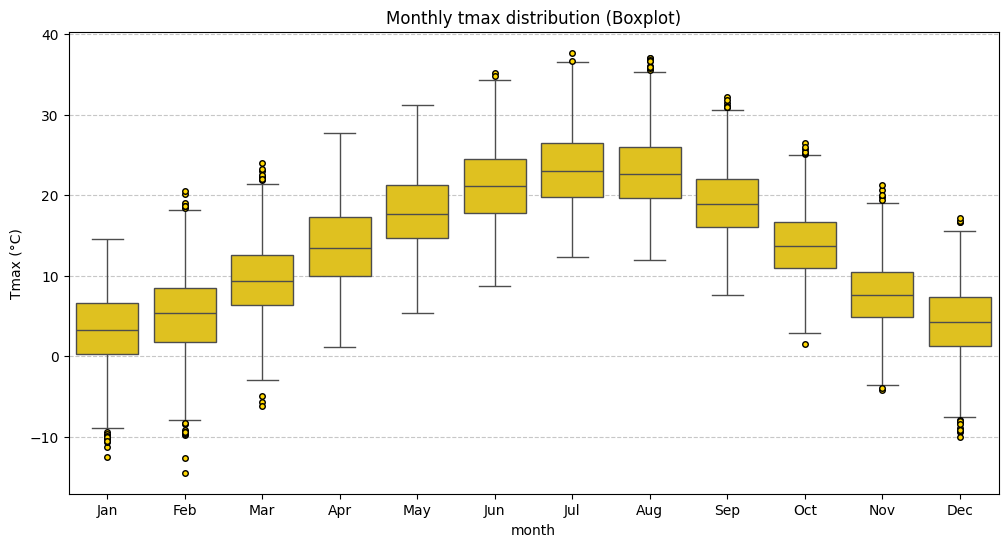

In [6]:
# Check for consistency and detect unrealistic outliers using boxplots

df['month'] = df['date'].dt.month

flierprops = {
    'marker': 'o',
    'markerfacecolor': 'gold',
    'markeredgecolor': 'black',
    'markersize': 4
}
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month', y='Tmax', color='gold', flierprops=flierprops)
plt.title('Monthly tmax distribution (Boxplot)')
plt.xlabel('month')
plt.ylabel('Tmax (°C)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# Only if the dataset has passed all consistency checks, save the pre-processed data for further analysis
dfp.to_csv(''+str(pfad)+'tmax_19510101_20241231_04336-Saarbruecken_prepr.csv', index=False)